# Linguistics Project

#### Goal: Predict Emotions from recorded speech

In [1]:
import numpy as np
import seaborn as sns
import wave
import os
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = '../data/Audio_Speech_Actors_01-24/Actor_07'
data_file = '03-01-01-01-01-01-07.wav'

data_path = os.path.join(data_dir, data_file)

In [3]:
#samples, sample_rate = sf.read(data_path)
raw_samples, sample_rate = librosa.load(data_path)
samples, index = librosa.effects.trim(raw_samples, top_db=30)

In [4]:
#STFT https://towardsdatascience.com/audio-processing-in-tensorflow-208f1a4103aa
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    # Take segments from the signal
    nperseg = int(round(window_size * sample_rate / 1e3))
    # provides a 'smoother' spec compared to with 0 overlap
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    # Transpose spec-matrix into a 32-float array
    spectrogram = spec.T.astype(np.float32)
    log_spectrogram = 10. * np.log10(spectrogram + eps)
    return freqs, times, log_spectrogram

Text(0.5,0,'Seconds')

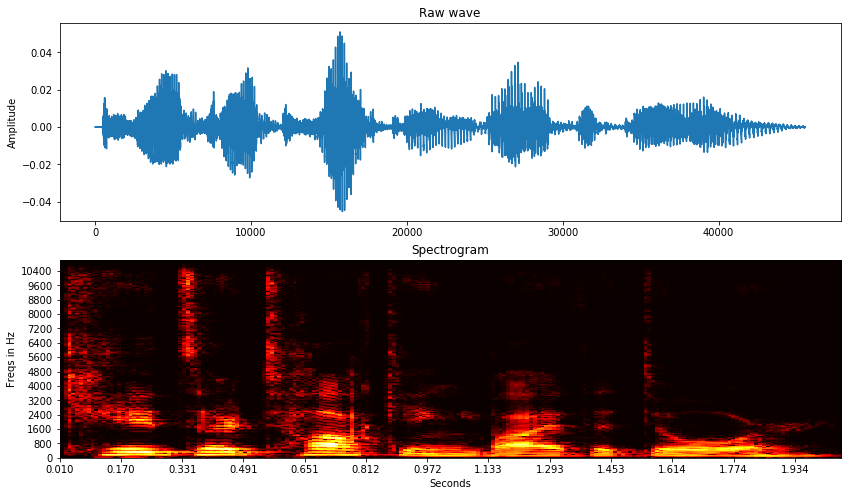

In [6]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_ylabel('Amplitude')
ax1.plot(samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', cmap='hot', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

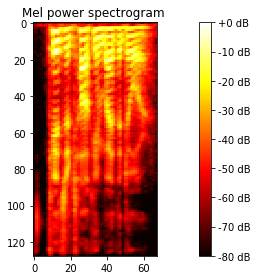

In [57]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
#librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.imshow(log_S, cmap='hot')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

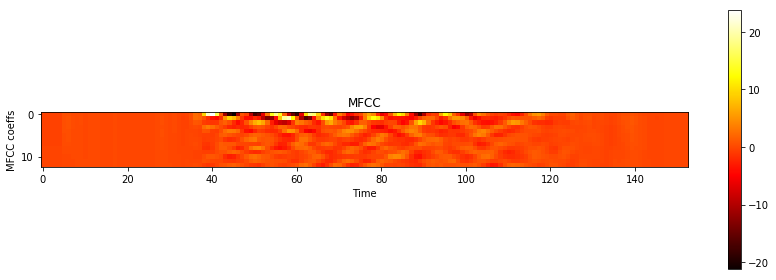

In [16]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
#librosa.display.specshow(delta2_mfcc)
plt.imshow(delta2_mfcc, cmap='hot')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()